# recurrent neural network (RNN) + Leu

In [1]:
import json
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)

## without Leu

In [5]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep notCys
select = df11[0].apply(lambda x: False if 'L' in x else True)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
False    1314625
True      550617
Name: count, dtype: int64
(550617, 2)
(3185991, 2) (3185991, 2)
(1863999, 2) (1863998, 2)


In [6]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(5600606, 2)


,0,1
1287923,LYKTPCTKRF,other
2733531,LYLVWAFIP,other
435627,RSCSQERKE,other
1163430,KLLQALHHF,other
92320,ACKVATEPITMS,random


In [7]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'LYKTPCTKRF')
Counter({'other': 3185991, 'random': 1863998, 'epitope': 550617})


In [8]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('other', 'AKSFGLRD')
split data:  3360363 1120121 1120122

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: TEEEATEFL ['T', 'E', 'E', 'E', 'A', 'T', 'E', 'F', 'L']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('S', 2706385), ('L', 2642447), ('A', 2607327), ('G', 2557619), ('E', 2490814), ('V', 2314985), ('P', 2268805), ('K', 2166535), ('T', 2119387), ('R', 2110869), ('D', 2049353), ('Q', 1851615), ('I', 1846511), ('N', 1692892), ('F', 1623820), ('Y', 1404476), ('H', 1314063), ('C', 1280825), ('M', 1234779), ('W', 1042794), ('X', 3192), ('U', 80), ('Z', 48), ('B', 41), ('J', 2)])
counts of input: [1912175, 1118450, 329738]

## Step 3 encoding: encoding each unique token into integers...


In [9]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.9207 val_acc: 0.9236, val_recall: 0.7039
Epoch 1 acc: 0.9255 val_acc: 0.9245, val_recall: 0.7364
Epoch 2 acc: 0.9271 val_acc: 0.9260, val_recall: 0.7219
Epoch 3 acc: 0.9279 val_acc: 0.9266, val_recall: 0.7098
Epoch 4 acc: 0.9287 val_acc: 0.9274, val_recall: 0.7269
Epoch 5 acc: 0.9291 val_acc: 0.9276, val_recall: 0.7218
Epoch 6 acc: 0.9296 val_acc: 0.9276, val_recall: 0.7292
Epoch 7 acc: 0.9299 val_acc: 0.9273, val_recall: 0.7518
Epoch 8 acc: 0.9302 val_acc: 0.9274, val_recall: 0.7228
Epoch 9 acc: 0.9304 val_acc: 0.9278, val_recall: 0.7443
Epoch 10 acc: 0.9306 val_acc: 0.9280, val_recall: 0.7433
Epoch 11 acc: 0.9306 val_acc: 0.9273, val_recall: 0.7528
Epoch 12 acc: 0.9307 val_acc: 0.9271, val_recall: 0.7478
Epoch 13 acc: 0.9309 val_acc: 0.9278, val_recall: 0.7405
Epoch 14 acc: 0.9309 val_acc: 0.9279, val_recall: 0.7390
Epoch 15 acc: 0.9311 val_acc: 0.9272, val_recall: 0.7642
Epoch 16 acc: 0.9311 val_acc: 0.9275, val_recall: 0.7563
Epoch 17 acc: 0.9310 val_acc: 0.9273, val

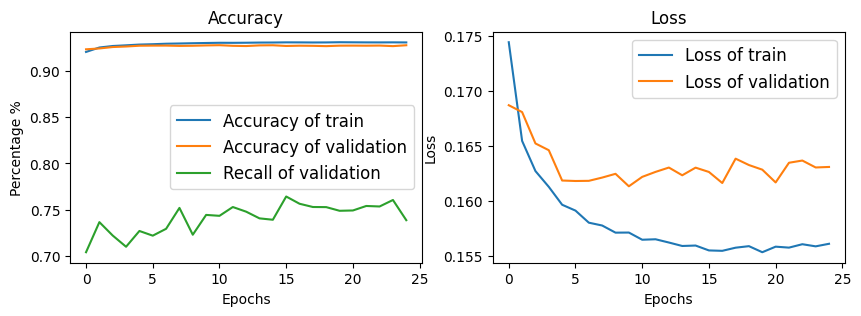

In [11]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [12]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7364804395715999,
 'accuracy': 0.927350770719618,
 'loss': 0.1640702186900512}

In [13]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]

110480 1009642


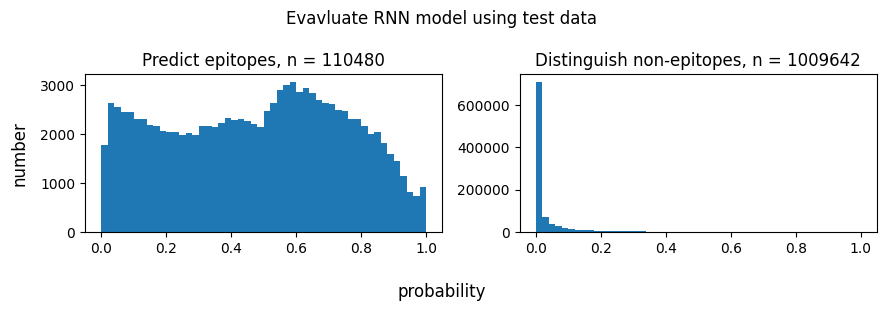

In [14]:
MyEvaluate.plot_prob(pred_test)

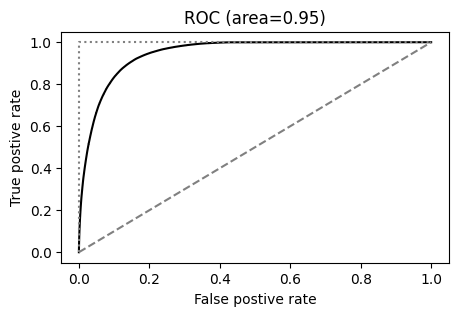

In [15]:
MyEvaluate.plot_roc(pred_test)

In [17]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_notLeu.pth')

## has Leu

In [18]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep Cys
select = df11[0].apply(lambda x: True if 'L' in x else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
True     1314625
False     550617
Name: count, dtype: int64
(1314625, 2)
(3185991, 2) (3185991, 2)
(1863999, 2) (1863998, 2)


In [19]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)

(6364614, 2)


In [20]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('epitope', 'DQPPALLVALDNLSD')
Counter({'other': 3185991, 'random': 1863998, 'epitope': 1314625})


In [21]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('random', 'MGAQSYDCSN')
split data:  3818768 1272922 1272924

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: RDGKLVSESSDVLPK ['R', 'D', 'G', 'K', 'L', 'V', 'S', 'E', 'S', 'S', 'D', 'V', 'L', 'P', 'K']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 4046817), ('S', 3091415), ('A', 3035529), ('G', 2858373), ('E', 2855455), ('V', 2697323), ('P', 2543320), ('K', 2517132), ('R', 2432852), ('T', 2404862), ('D', 2333252), ('I', 2132431), ('Q', 2107801), ('N', 1929980), ('F', 1843878), ('Y', 1582913), ('H', 1455355), ('C', 1347713), ('M', 1344462), ('W', 1099308), ('X', 3119), ('U', 79), ('B', 57), ('Z', 45), ('J', 6)])
counts of input: [1912666, 1117425, 788677]

## Step 3 encoding: encoding each unique token into integers...


In [22]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8437 val_acc: 0.8505, val_recall: 0.7256


In [ ]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [ ]:
# test model using test data
res = p.test(test_ds)
res

In [ ]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

In [ ]:
MyEvaluate.plot_prob(pred_test)

In [ ]:
MyEvaluate.plot_roc(pred_test)

In [ ]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_Leu.pth')